# Nutrition Tracker Survival Analysis
Created by: Andy Luc

## Business case:
Health and fitness has always been a topic of interest to me and I am fairly active when it comes to staying in shape. Part of that journey involves the consistency of tracking nutritional intake. One of the most popular apps today is MyFitnessPal, which tracks this on a daily basis.

Based on only user inputs of daily food intake and a target goal:
1. Can we predict when a user decides to churn or quit tracking their progress on the app?
2. Is there a certain nutritional item (calories, carbs, fat, fiber, protein, sodium, sugar) that contributes to a user quitting the platform sooner?

Additional question:
3. Based on only user inputs of daily food intake, can we find out if a user will stop using the app within a 6 month time frame?

### Pickled files:
Save processing time when loading into a dataframe.

- final_churn.pkl
- df.pkl


In [5]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from functions import daily_totals, daily_goals, merge, parsed_dict, json
from lifelines import CoxPHFitter, KaplanMeierFitter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploratory Data Analysis

In [3]:
# Reading the data file
data = pd.read_csv('data/mfp-diaries.tsv',
                  sep='\t',
                  header=None,
                  names=['userid','diary_date','food_entries','daily_goal'])

In [4]:
data.head()

,userid,diary_date,food_entries,daily_goal
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [5]:
# Number of unique users
len(data['userid'].unique())

9896

### Setting up dataframe for Survival Analysis
Since we are concerned with when a user decides to stop using the MyFitnessPal program based on their input attributes, I am going to focus on the *diary_date* and *daily_goal* columns. First, we need to parse the nested dictionary within the daily_goal column.

In [6]:
# Parsing only the dialy_goals column
mark = data.drop(['userid', 'diary_date','food_entries'], axis=1)

In [21]:
mark.head()

,daily_goal
0,"{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,"{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,"{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,"{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,"{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [8]:
# Loading into json format for extraction
target = json.loads(mark['daily_goal'][0])
target

{'total': [{'name': 'Calories', 'value': 2924},
  {'name': 'Carbs', 'value': 340},
  {'name': 'Fat', 'value': 114},
  {'name': 'Protein', 'value': 186},
  {'name': 'Sodium', 'value': 3658},
  {'name': 'Sugar', 'value': 109}],
 'goal': [{'name': 'Calories', 'value': 3173},
  {'name': 'Carbs', 'value': 396},
  {'name': 'Fat', 'value': 105},
  {'name': 'Protein', 'value': 160},
  {'name': 'Sodium', 'value': 2300},
  {'name': 'Sugar', 'value': 119}]}

In [25]:
total_dict = daily_totals(target)

In [26]:
goal_dict = daily_goals(target)

In [27]:
merge(total_dict, goal_dict)

{'total_calories': 2924,
 'total_carbs': 340,
 'total_fat': 114,
 'total_protein': 186,
 'total_sodium': 3658,
 'total_sugar': 109,
 'goal_calories': 3173,
 'goal_carbs': 396,
 'goal_fat': 105,
 'goal_protein': 160,
 'goal_sodium': 2300,
 'goal_sugar': 119}

In [36]:
full_list = parsed_dict(mark, target)

In [37]:
# Putting it back into a pandas dataframe
new_mark = pd.DataFrame(full_list)
new_mark.head()

,goal_calcium,goal_calories,goal_carbs,goal_chol,goal_fat,goal_fiber,goal_iron,goal_mon fat,goal_ply fat,goal_potass.,...,total_mon fat,total_ply fat,total_potass.,total_protein,total_sat fat,total_sodium,total_sugar,total_trn fat,total_vit a,total_vit c
0,NaN,3173.0,396.0,NaN,105.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,186.0,NaN,3658.0,109.0,NaN,NaN,NaN
1,NaN,1572.0,196.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50.0,NaN,855.0,63.0,NaN,NaN,NaN
2,NaN,1832.0,229.0,NaN,61.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,114.0,NaN,2215.0,100.0,NaN,NaN,NaN
3,NaN,1685.0,210.0,NaN,56.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,98.0,NaN,1765.0,105.0,NaN,NaN,NaN
4,NaN,1597.0,199.0,NaN,53.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,202.0,NaN,1101.0,71.0,NaN,NaN,NaN


In [38]:
# Merging the original dataframe with the newly parsed daily_goal column
con = pd.concat([data, new_mark], axis=1)

In [39]:
# Looking at the number of null values for each column
con.isna().sum()

userid                 0
diary_date             0
food_entries           0
daily_goal             0
goal_calcium      564262
goal_calories          7
goal_carbs         14145
goal_chol         568935
goal_fat           17859
goal_fiber        344347
goal_iron         558171
goal_mon fat      587096
goal_ply fat      586693
goal_potass.      567771
goal_protein        7321
goal_sat fat      570611
goal_sodium       196659
goal_sugar        218272
goal_trn fat      585359
goal_vit a        586413
goal_vit c        584701
total_calcium     564262
total_calories        26
total_carbs        14146
total_chol        568935
total_fat          17866
total_fiber       344349
total_iron        558171
total_mon fat     586759
total_ply fat     586426
total_potass.     567771
total_protein       7331
total_sat fat     570611
total_sodium      196660
total_sugar       218270
total_trn fat     585359
total_vit a       586413
total_vit c       584701
dtype: int64

In [40]:
# Dropping columns which have high null values which are not beneficial to the features being used
total_goal = con.drop(['food_entries','daily_goal','goal_calcium','goal_chol',
                       'goal_iron','goal_mon fat','goal_ply fat','goal_potass.',
                       'goal_sat fat','goal_trn fat','goal_vit a','goal_vit c',
                       'total_calcium','total_chol','total_iron','total_mon fat',
                       'total_ply fat','total_potass.','total_sat fat','total_trn fat',
                       'total_vit a','total_vit c'], axis=1)

In [41]:
# Fill the remaining null values of each nutrient with 0
total_goal.fillna(0, inplace=True)

In [42]:
# Changing diary_date column to a datetime type
total_goal['diary_date'] = pd.to_datetime(total_goal['diary_date'])

In [43]:
total_goal.head()

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar
0,1,2014-09-14,3173.0,396.0,105.0,0.0,160.0,2300.0,119.0,2924.0,340.0,114.0,0.0,186.0,3658.0,109.0
1,1,2014-09-15,1572.0,196.0,52.0,0.0,79.0,2300.0,59.0,2430.0,96.0,37.0,0.0,50.0,855.0,63.0
2,1,2014-09-16,1832.0,229.0,61.0,0.0,92.0,2300.0,69.0,1862.0,158.0,54.0,0.0,114.0,2215.0,100.0
3,1,2014-09-17,1685.0,210.0,56.0,0.0,85.0,2300.0,63.0,2251.0,187.0,60.0,0.0,98.0,1765.0,105.0
4,1,2014-09-18,1597.0,199.0,53.0,0.0,80.0,2300.0,60.0,2001.0,113.0,81.0,0.0,202.0,1101.0,71.0


### Create 1 column per dictionary in both total key and goal key

- total
    + total_calories
    + total_carbs
    + total_fat
    + total_fiber
    + total_protein
    + total_sodium
    + total_sugar
- goal
    + goal_calories
    + goal_carbs
    + goal_fat
    + goal_fiber
    + goal_protein
    + goal_sodium
    + goal_sugar


Add additional columns:
- **total_sum**: Total sum of input values for the day
- **goal_sum**: Total sum of goal values for the day
- **achievement**: Indicates whether or not a user has met their daily goal within a tolerance of 10%.
    - 1 = Succeed
    - 0 = Fail

In [46]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

total_s = []
goal_s = []
for nutrient in nutrients:
    total_s.append(f'total_{nutrient}')
    goal_s.append(f'goal_{nutrient}')

total_goal['total_sum'] = total_goal[total_s].apply(np.sum, axis=1)

total_goal['goal_sum'] = total_goal[goal_s].apply(np.sum, axis=1)

total_goal['achievement'] = np.where(abs((total_goal['total_sum'] - 
                                          total_goal['goal_sum']) / 
                                          total_goal['goal_sum']) <= 0.1, 1, 0)

In [47]:
coll = total_goal.drop(['userid','diary_date','goal_calories','goal_carbs',
                        'goal_fat','goal_fiber','goal_protein','goal_sodium',
                        'goal_sugar','total_sum','goal_sum'], axis=1)

### Create Multi-Collinearity Heatmap
This is just to show if any columns have collinear values. We would essentially drop a certain column if the value they are highly correlated, but in this case we want to keep the features as they may pertain to the survival analysis model. As you can see sugar and carbs are correlated, which we can say is a true statement.

Text(0.5, 1.0, 'Multi-Collinearity of Attributes')

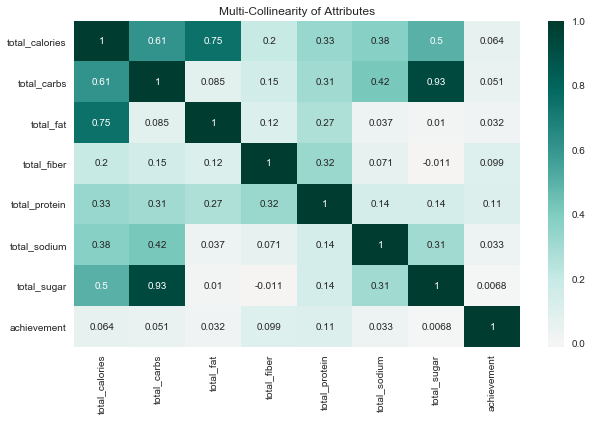

In [48]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(coll.corr(), center=0, cmap='BrBG', annot=True)

ax.set_title('Multi-Collinearity of Attributes')

## Survival Analysis
Min & Max Diary Dates: Sept 14, 2014 - Apr 9, 2015
1. duration_col = length of time between start date and time of churn
2. event_col = time of churn (when there is a break >=5 days)
    * churn = 1
    * continuous = 0

In [ ]:
for index, row in total_goal.iterrows():
    if (index != len(total_goal) - 1):
        total_goal.loc[index, 'end_date'] = total_goal.loc[index + 1, 'diary_date']

In [52]:
total_goal.loc[0, 'end_date'] - total_goal.loc[0, 'diary_date']

Timedelta('1 days 00:00:00')

In [53]:
prev_user = ''
start_date = None
churn_date = None
churned = False

prev_user = total_goal.loc[0, 'userid']
start_date = total_goal.loc[0, 'diary_date']

result = []
for index, row in total_goal.iterrows():        
    user = row['userid']
    if prev_user == user:
        # Same user check churn date
        if (row['end_date'] - row['diary_date']) >= pd.Timedelta(5, 'D'):
            if not churned:
                churn_date = row['diary_date']
                record = {'userid':user, 
                          'start_date': start_date,
                          'churn_date': churn_date}
                result.append(record)
                churned = True        
    else:
        # Next user
        if not churned:
            record = {'userid':prev_user, 
                      'start_date': start_date,
                      'churn_date': ''}
            result.append(record)
        start_date = row['diary_date']
        churned = False
        prev_user = user

In [54]:
end_date = pd.DataFrame(result)
end_date.head()

,churn_date,start_date,userid
0,2014-11-01,2014-09-14,1
1,NaT,2015-01-12,2
2,2014-09-23,2014-09-14,3
3,2014-10-22,2014-10-21,4
4,NaT,2014-09-14,5


In [55]:
end_date['days'] = (end_date['churn_date'] - end_date['start_date']).dt.days
end_date.head()

,churn_date,start_date,userid,days
0,2014-11-01,2014-09-14,1,48.0
1,NaT,2015-01-12,2,NaN
2,2014-09-23,2014-09-14,3,9.0
3,2014-10-22,2014-10-21,4,1.0
4,NaT,2014-09-14,5,NaN


In [56]:
end_date['churn_5days'] = end_date['churn_date'].apply(lambda x: 0 if type(x) is not pd.Timestamp else 1)
end_date.head()

,churn_date,start_date,userid,days,churn_5days
0,2014-11-01,2014-09-14,1,48.0,1
1,NaT,2015-01-12,2,NaN,0
2,2014-09-23,2014-09-14,3,9.0,1
3,2014-10-22,2014-10-21,4,1.0,1
4,NaT,2014-09-14,5,NaN,0


In [57]:
days_count = total_goal['userid'].value_counts().sort_index()
days_count = pd.DataFrame(days_count).rename(columns={'userid': 'days_count'})
days_count.head()

,days_count
1,174
2,60
3,7
4,27
5,179


In [58]:
final_churn = pd.merge(days_count, end_date, left_index=True, right_on='userid')
final_churn.index = final_churn['userid']
final_churn = final_churn.drop('userid', axis=1)

In [59]:
final_churn.head()

,days_count,churn_date,start_date,days,churn_5days
userid,,,,,
1,174,2014-11-01,2014-09-14,48.0,1
2,60,NaT,2015-01-12,NaN,0
3,7,2014-09-23,2014-09-14,9.0,1
4,27,2014-10-22,2014-10-21,1.0,1
5,179,NaT,2014-09-14,NaN,0


In [60]:
final_churn.days.fillna(final_churn.days_count, inplace=True)
final_churn.head()

,days_count,churn_date,start_date,days,churn_5days
userid,,,,,
1,174,2014-11-01,2014-09-14,48.0,1
2,60,NaT,2015-01-12,60.0,0
3,7,2014-09-23,2014-09-14,9.0,1
4,27,2014-10-22,2014-10-21,1.0,1
5,179,NaT,2014-09-14,179.0,0


### Exploratory Analysis with final churn dataframe

In [61]:
user = total_goal[total_goal['userid'] == 3]

print(user.diary_date.diff().value_counts())
print('\n')
print(user.diary_date.value_counts().sum())

user[user.diary_date.diff() > pd.Timedelta(3, 'D')]

1 days    5
4 days    1
Name: diary_date, dtype: int64


7


,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
240,3,2014-09-23,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,1208.0,173.0,30.0,11.0,34.0,1707.0,0.0,3163.0,3786.0,0,2014-10-21


### Merging "final_churn" and "total_goal" dataframes

In [62]:
cols = total_goal.drop(['userid','diary_date'], axis=1).columns

condense = total_goal.groupby(['userid'])[cols].sum()

unite = pd.merge(final_churn, condense, left_index=True, right_index=True)

In [63]:
unite.head()

,days_count,churn_date,start_date,days,churn_5days,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,...,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
userid,,,,,,,,,,,,,,,,,,,,,
1,174,2014-11-01,2014-09-14,48.0,1,375085.0,46633.0,12472.0,0.0,19029.0,...,401750.0,32265.0,13562.0,0.0,22408.0,360487.0,14227.0,844699.0,867495.0,68
2,60,NaT,2015-01-12,60.0,0,90925.0,11387.0,2955.0,0.0,4714.0,...,87430.0,10872.0,2537.0,0.0,2550.0,100217.0,4573.0,208179.0,251403.0,11
3,7,2014-09-23,2014-09-14,9.0,1,9438.0,1178.0,312.0,196.0,469.0,...,11969.0,811.0,267.0,120.0,323.0,10156.0,0.0,23646.0,27693.0,2
4,27,2014-10-22,2014-10-21,1.0,1,44211.0,5524.0,1464.0,0.0,2223.0,...,24636.0,2682.0,1001.0,0.0,1153.0,40061.0,0.0,69533.0,115522.0,4
5,179,NaT,2014-09-14,179.0,0,572414.0,0.0,15948.0,7564.0,35677.0,...,536631.0,0.0,13818.0,6305.0,33720.0,358700.0,21707.0,970881.0,1064788.0,58


In [64]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

for nutrient in nutrients:
    total = unite[f'total_{nutrient}']
    goal = unite[f'goal_{nutrient}']
    unite[f'{nutrient}_10_pct'] = np.where(abs((total - goal) / goal) <= 0.1, 1, 0)

In [65]:
unite.head()

,days_count,churn_date,start_date,days,churn_5days,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,...,total_sum,goal_sum,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,,,,,,,,,,,,
1,174,2014-11-01,2014-09-14,48.0,1,375085.0,46633.0,12472.0,0.0,19029.0,...,844699.0,867495.0,68,1,0,1,0,0,1,1
2,60,NaT,2015-01-12,60.0,0,90925.0,11387.0,2955.0,0.0,4714.0,...,208179.0,251403.0,11,1,1,0,0,0,0,0
3,7,2014-09-23,2014-09-14,9.0,1,9438.0,1178.0,312.0,196.0,469.0,...,23646.0,27693.0,2,0,0,0,0,0,0,0
4,27,2014-10-22,2014-10-21,1.0,1,44211.0,5524.0,1464.0,0.0,2223.0,...,69533.0,115522.0,4,0,0,0,0,0,0,0
5,179,NaT,2014-09-14,179.0,0,572414.0,0.0,15948.0,7564.0,35677.0,...,970881.0,1064788.0,58,1,0,0,0,1,0,1


In [66]:
unite.drop(unite.columns.difference(['days','churn_5days','achievement','calories_10_pct',
                                          'carbs_10_pct','fat_10_pct','fiber_10_pct','protein_10_pct',
                                          'sodium_10_pct','sugar_10_pct']), 1, inplace=True)

In [67]:
df = unite
df.head()

,days,churn_5days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,48.0,1,68,1,0,1,0,0,1,1
2,60.0,0,11,1,1,0,0,0,0,0
3,9.0,1,2,0,0,0,0,0,0,0
4,1.0,1,4,0,0,0,0,0,0,0
5,179.0,0,58,1,0,0,0,1,0,1


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9896 entries, 1 to 9897
Data columns (total 10 columns):
days               9896 non-null float64
churn_5days        9896 non-null int64
achievement        9896 non-null int64
calories_10_pct    9896 non-null int64
carbs_10_pct       9896 non-null int64
fat_10_pct         9896 non-null int64
fiber_10_pct       9896 non-null int64
protein_10_pct     9896 non-null int64
sodium_10_pct      9896 non-null int64
sugar_10_pct       9896 non-null int64
dtypes: float64(1), int64(9)
memory usage: 1.1 MB


### 5 day Churn:

In [3]:
df = pd.read_pickle('df.pkl')
df.head()

,days,churn_5days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,48.0,1,68,1,0,1,0,0,1,1
2,60.0,0,11,1,1,0,0,0,0,0
3,9.0,1,2,0,0,0,0,0,0,0
4,1.0,1,4,0,0,0,0,0,0,0
5,179.0,0,58,1,0,0,0,1,0,1


In [6]:
cph = CoxPHFitter()
five_days = cph.fit(df, duration_col='days', event_col='churn_5days')
five_days.print_summary()

<lifelines.CoxPHFitter: fitted with 9896 observations, 2789 censored>
      duration col = 'days'
         event col = 'churn_5days'
number of subjects = 9896
  number of events = 7107
partial log-likelihood = -58751.44
  time fit was run = 2019-07-03 08:24:11 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.04      0.96      0.00 -36.46 <0.005    964.51       -0.04       -0.03
calories_10_pct -0.02      0.98      0.04  -0.51   0.61      0.71       -0.09        0.05
carbs_10_pct     0.06      1.07      0.04   1.68   0.09      3.42       -0.01        0.14
fat_10_pct       0.13      1.14      0.03   4.18 <0.005     15.07        0.07        0.19
fiber_10_pct     0.15      1.16      0.08   1.91   0.06      4.17       -0.00        0.31
protein_10_pct  -0.13      0.88      0.05  -2.79   0.01      7.56       -0.22       -0.04
sodium_10_pct    0.10      1.11      0.04   2.56   0.01      6.59        0.02        0.18
sugar_10_p

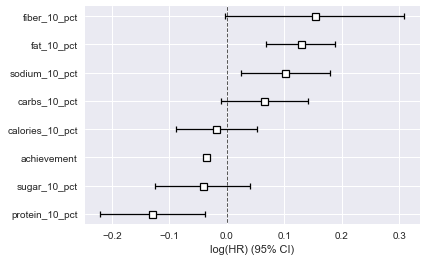

In [22]:
five_days.plot()

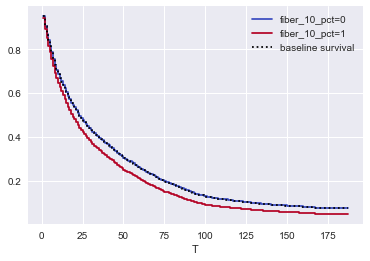

In [25]:
cph.plot_covariate_groups('fiber_10_pct', [0, 1], cmap='coolwarm')

y-axis = risk
at 25 days, there is a lower risk of churning based only on meeting sodium goals

## Logistic Regression

In [26]:
df.head()

,days,churn_5days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,48.0,1,68,1,0,1,0,0,1,1
2,60.0,0,11,1,1,0,0,0,0,0
3,9.0,1,2,0,0,0,0,0,0,0
4,1.0,1,4,0,0,0,0,0,0,0
5,179.0,0,58,1,0,0,0,1,0,1


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score, accuracy_score,
f1_score, confusion_matrix, classification_report)

In [135]:
#Setting X and y variables, then Train Test Split
X = df.drop(['churn_5days'], axis=1)
y = df.churn_5days

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [136]:
loreg = LogisticRegression(solver='lbfgs', max_iter=1000)
loreg.fit(X_train, y_train)
loreg_preds = loreg.predict(X_test)

In [137]:
def print_metrics(y, loreg_preds):
    print("Precision Score: {}".format(precision_score(y, loreg_preds)))
    print("Recall Score: {}".format(recall_score(y, loreg_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y, loreg_preds)))
    print("F1 Score: {}".format(f1_score(y, loreg_preds)))
    
print_metrics(y_test, loreg_preds)

Precision Score: 0.7763888888888889
Recall Score: 0.9469226425748165
Accuracy Score: 0.7667744543249798
F1 Score: 0.8532180106843044


In [138]:
print(classification_report(y_test, loreg_preds))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43       703
           1       0.78      0.95      0.85      1771

   micro avg       0.77      0.77      0.77      2474
   macro avg       0.74      0.63      0.64      2474
weighted avg       0.75      0.77      0.73      2474



In [139]:
X_train.head()

,days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,
4883,3.0,4,0,0,0,0,0,0,0
1448,179.0,98,1,0,0,0,0,0,0
4705,37.0,10,0,1,0,0,0,0,0
5601,24.0,32,1,0,1,0,0,1,0
3120,179.0,34,0,1,1,0,0,0,0


In [140]:
m = np.array((50, 1, 0, 1, 0, 0, 0, 0, 0))
m_df = pd.DataFrame(m).T
m_df

,0,1,2,3,4,5,6,7,8
0,50,1,0,1,0,0,0,0,0


In [141]:
loreg.predict(m_df)

array([1])

AUC: 0.7013597448380057


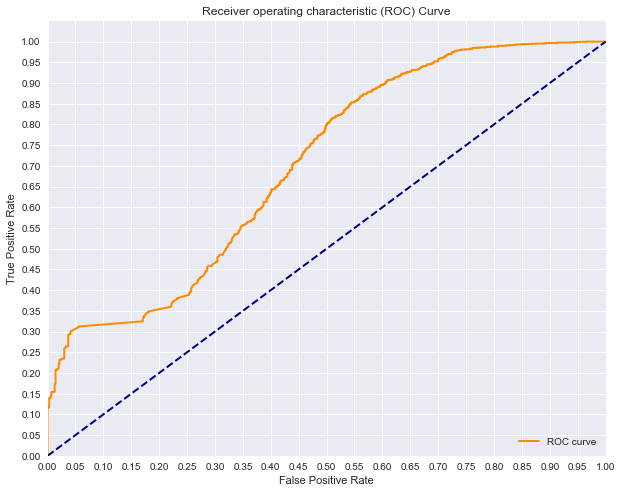

In [142]:
y_score = loreg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Time Series Analysis

In [ ]:
total_goal_df.head()

In [ ]:
irrelevant = ['goal_calories','goal_carbs','goal_fat','goal_fiber','goal_protein',
              'goal_sodium','goal_sugar','total_calories','total_carbs','total_fat',
              'total_fiber','total_protein','total_sodium','total_sugar','achievement']

time_df = total_goal_df.drop(irrelevant, axis=1)

In [ ]:
time_df.head()

In [ ]:
time_df['tg_diff'] = round(abs((time_df['total_sum'] - time_df['goal_sum'])/time_df['goal_sum']), 3)

In [ ]:
# time_df['tg_diff'] = pd.Series(["{0:.2f}%".format(val * 100) for val in time_df['tg_diff']])

In [ ]:
time_df = time_df.drop(['total_sum','goal_sum'], axis=1)

In [ ]:
time_df.set_index('diary_date', inplace=True)

In [ ]:
time_df.head()

In [ ]:
new_time_df = pd.DataFrame(time_df[(time_df['userid']==1)|(time_df['userid']==2)])

In [ ]:
new_time_df.head()

In [ ]:
by_label = new_time_df.groupby('userid')

for name, group in by_label:
    plt.plot(group['tg_diff'], label=name)

plt.legend()
plt.show()

In [ ]:
# json_dict.keys()[0]
# Gives Error: 'dict_keys' object does not support indexing, hence needs to be set to a list to iterate.

In [ ]:
# df = pd.DataFrame([[1, 4],
#                    [2, 5],
#                    [3, 6]],
#                   columns=["a", "b"])
# df

In [ ]:
# df["c"] = df.apply(np.sum, axis=1)
# df

## K Means Clustering

In [ ]:
survival_per_day = pd.read_pickle('survival_per_day.pkl')

In [ ]:
survival_per_day.head()

In [ ]:
survival_per_day = survival_per_day.drop(['days','achievement'], axis=1)

In [ ]:
cluster_df = survival_per_day

In [ ]:
cluster_df.head()

In [ ]:
combine_df = combine_df.drop(['achievement'],axis=1)

In [ ]:
combine_df.head()

In [ ]:
combine_df['achievement'] = np.where(abs((combine_df['total_sum'] - 
                                          combine_df['goal_sum']) / 
                                          combine_df['goal_sum']) <= 0.1, 1, 0)
combine_df.head()

In [ ]:
combine_df = combine_df.drop(['goal_calories','goal_carbs','goal_fat','goal_fiber','goal_protein',
                              'goal_sodium','goal_sugar','total_calories','total_carbs','total_fat',
                              'total_fiber','total_protein','total_sodium','total_sugar','total_sum','goal_sum'],
                             axis=1)

In [ ]:
combine_df.head()

In [ ]:
cluster_log = pd.merge(cluster_df, combine_df, left_index=True, right_index=True)

In [ ]:
cluster_log.head()

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
cluster_log.head()

In [ ]:
cluster_log = cluster_log.drop(['days'], axis=1)

In [ ]:
cluster_log.head()

In [ ]:
ss = StandardScaler()
scaled_data = ss.fit_transform(cluster_log.astype(float))

In [ ]:
scaled_df=pd.DataFrame(data=scaled_data, columns=cluster_log.columns)
scaled_df.head()

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(data=pca_data, columns=['pca1', 'pca2'])
pca_df.head()

In [ ]:
X = scaled_data
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    
plt.figure(figsize=(10,5))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.grid(True)

In [ ]:
model = KMeans(n_clusters=4, random_state=10).fit(pca_df)
model_label = model.labels_
model_centers = model.cluster_centers_
sorted(model_centers.tolist())

In [ ]:
plt.figure(figsize=(10,8))

plt.title('K-Means Clustering')
plt.xlabel('pca1')
plt.ylabel('pca2')

scatter = plt.scatter(pca_df['pca1'], pca_df['pca2'], c=model_label, s=25, cmap='RdBu_r')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='*');

In [ ]:
pca_components = pd.DataFrame(pca.components_, columns=cluster_log.columns)
pca_components.head()

In [ ]:
# Limits only rows with userid's with greater than 2 days of inputs

# counts = total_goal['userid'].value_counts()
# s_res = total_goal[~total_goal['userid'].isin(counts[counts <= 2].index)]
# s_res['userid'].value_counts().tail()